# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
from datetime import datetime
import multiprocessing as mp
import pandas as pd
import numpy as np
import scipy
import sklearn.preprocessing
import sklearn.metrics
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool


# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')

# Обзор данных
Проверяем данные, есть ли с ними явные проблемы.

In [3]:
display(tracks.sample(5))
tracks.dtypes

,track_id,albums,artists,genres
503548,34858933,"[4312830, 4314396, 4322568]",[29692],"[14, 102]"
318405,20643583,[2353738],[1632340],[335]
400974,27290173,[3265133],[3160589],[68]
827323,65591187,"[10624681, 13520862]",[6108516],"[44, 75]"
131094,2449117,[242764],"[33224, 184702]","[68, 86]"


track_id     int64
albums      object
artists     object
genres      object
dtype: object

In [4]:
display(catalog_names.sample(5))
display(catalog_names.dtypes)
catalog_names.type.value_counts()

,id,type,name
1744170,80910076,track,Люблю тебя
1734965,79239267,track,500 рублей
825502,77118,track,Apologize
1567116,57500071,track,Remind
1086355,17269320,track,Ti penso raramente


id       int64
type    object
name    object
dtype: object

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [5]:
catalog_names.type = catalog_names.type.astype('category')
catalog_names.dtypes

id         int64
type    category
name      object
dtype: object

In [6]:
display(interactions.sample(5))
interactions.dtypes

,user_id,track_id,track_seq,started_at
398,1008100,45713011,399,2022-09-18
442,879312,24442534,443,2022-09-21
4,952391,457611,5,2022-05-01
1076,1272925,31073436,1077,2022-08-18
1050,800785,33307983,1051,2022-09-18


user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object

In [7]:
# все трэки есть в catalog_names
tracks.track_id.isin(catalog_names[catalog_names.type=='track'].id).nunique()

1

Есть ли треки с неизвестными исполнителями, альбомами, жанрами?

In [8]:
%%time
albums = catalog_names[catalog_names.type=='album']
albums_ids = np.array(albums.id.values.tolist())
def check_albums(track_items):
    return True in [item_id in albums_ids for item_id in track_items]
with mp.Pool(mp.cpu_count()) as pool:
    tracks['albums_ok'] = pool.map(check_albums, tracks.albums)
tracks.albums_ok.value_counts()

CPU times: user 3.15 s, sys: 2.21 s, total: 5.36 s
Wall time: 39.1 s


albums_ok
True     999982
False        18
Name: count, dtype: int64

In [9]:
%%time
genres = catalog_names[catalog_names.type=='genre']
genres_ids = np.array(genres.id.values.tolist())
def check_genres(track_items):
    return True in [item_id in genres_ids for item_id in track_items]
with mp.Pool(mp.cpu_count()) as pool:
    tracks['genres_ok'] = pool.map(check_genres, tracks.genres)
tracks.genres_ok.value_counts()

CPU times: user 1.33 s, sys: 1.87 s, total: 3.21 s
Wall time: 3.42 s


genres_ok
True     996306
False      3694
Name: count, dtype: int64

In [10]:
%%time
artists = catalog_names[catalog_names.type=='artist']
artists_ids = np.array(artists.id.values.tolist())
def check_artists(track_items):
    return True in [item_id in artists_ids for item_id in track_items]
with mp.Pool(mp.cpu_count()) as pool:
    tracks['artists_ok'] = pool.map(check_artists, tracks.artists)
tracks.artists_ok.value_counts()

CPU times: user 2.92 s, sys: 2.31 s, total: 5.23 s
Wall time: 7.39 s


artists_ok
True     984631
False     15369
Name: count, dtype: int64

In [11]:
%%time
# Удаление
tracks = tracks.query("artists_ok==True and albums_ok==True and genres_ok==True")
interactions = interactions[interactions.track_id.isin(tracks.track_id)]

CPU times: user 4.98 s, sys: 727 ms, total: 5.71 s
Wall time: 5.7 s


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

В catalog_names поле type было преобразовано в категорию;
Найдено 18 трэков у которых ни один из альбомов не присутствует в catalog_names;
Найдено 3694 трэка у которых ни один из жанров не присутствует в catalog_names;
Найдено 15369 трэков у которых ни один из артистов не присутствует в catalog_names;

Удалять их необязательно?

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

array([[<Axes: title={'center': 'track_id'}>]], dtype=object)

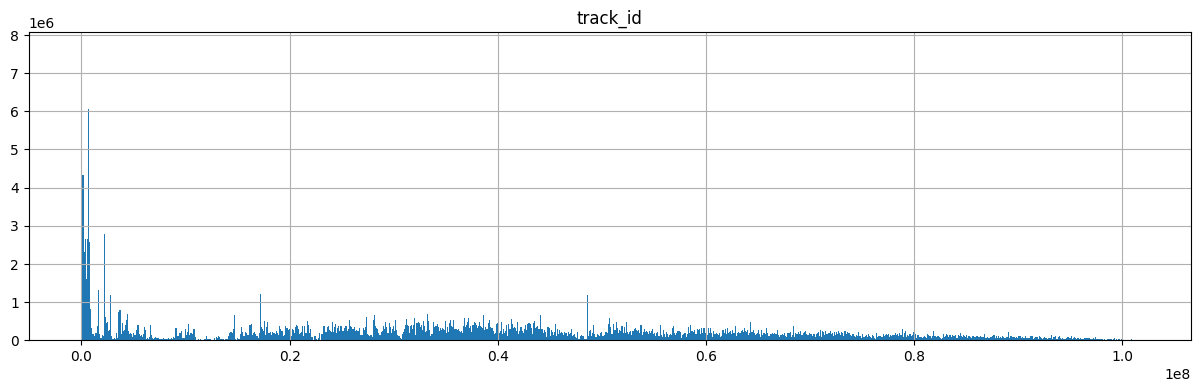

In [12]:
interactions.hist(column='track_id', bins=1000, figsize=(15,4))

In [13]:
top100tracks = tracks[tracks.track_id.isin(interactions.track_id.value_counts()[:100].index)]

Наиболее популярные треки

In [14]:
tracks_catalog = catalog_names[catalog_names.type=='track']
top100tracks_catalog = tracks_catalog[tracks_catalog.id.isin(top100tracks.track_id)]
top100tracks_catalog = top100tracks_catalog.rename({'id': 'track_id'}, axis=1)
def get_list(df, ids):
    return ', '.join(df[df.id.isin(ids)].name)
top100tracks['artists_names'] = top100tracks.apply(lambda row: get_list(artists, row.artists), axis=1)
top100tracks['genres_names'] = top100tracks.apply(lambda row: get_list(genres, row.genres), axis=1)
top100tracks.merge(top100tracks_catalog, on='track_id')[['track_id', 'artists_names', 'name', 'genres_names']]

/tmp/ipykernel_277730/3775954581.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top100tracks['artists_names'] = top100tracks.apply(lambda row: get_list(artists, row.artists), axis=1)
/tmp/ipykernel_277730/3775954581.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top100tracks['genres_names'] = top100tracks.apply(lambda row: get_list(genres, row.genres), axis=1)


,track_id,artists_names,name,genres_names
0,10216,Scorpions,Wind Of Change,"hardrock, allrock"
1,37384,The Cranberries,Zombie,"rock, allrock"
2,48951,Bon Jovi,It's My Life,"rock, hardrock, allrock"
3,52100,No Doubt,Don't Speak,pop
4,53404,Nirvana,Smells Like Teen Spirit,"alternative, rock, allrock"
...,...,...,...,...
95,78426489,Minelli,Rampampam,dance
96,81848875,Galibri & Mavik,Федерико Феллини,"pop, ruspop"
97,83063895,HammAli & Navai,Птичка,"pop, ruspop"
98,84382282,"Markul, Джарахов",Я в моменте,"rusrap, rap"


Наиболее популярные жанры

In [15]:
# cм выше

Треки, которые никто не прослушал

In [16]:
tracks[~tracks.track_id.isin(interactions.track_id)]
# таких нет

,track_id,albums,artists,genres,albums_ok,genres_ok,artists_ok


In [17]:
interactions.groupby(['user_id', 'track_id'])['track_seq'].count().nunique()

1

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [18]:
tracks_catalog = tracks_catalog.rename({'id': 'track_id'}, axis=1)

In [19]:
tracks.merge(tracks_catalog, on='track_id')

,track_id,albums,artists,genres,albums_ok,genres_ok,artists_ok,type,name
0,26,"[3, 2490753]",[16],"[11, 21]",True,True,True,track,Complimentary Me
1,38,"[3, 2490753]",[16],"[11, 21]",True,True,True,track,Momma's Boy
2,135,"[12, 214, 2490809]",[84],[11],True,True,True,track,Atticus
3,136,"[12, 214, 2490809]",[84],[11],True,True,True,track,24 Hours
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],True,True,True,track,Don't Upset The Rhythm (Go Baby Go)
...,...,...,...,...,...,...,...,...,...
980965,101478482,[21399811],[5540395],"[3, 75]",True,True,True,track,На лицо
980966,101490148,[21403052],[9078726],"[11, 20]",True,True,True,track,Без капли мысли
980967,101493057,[21403883],[11865715],"[44, 75]",True,True,True,track,SKITTLES
980968,101495927,[21404975],[4462686],"[3, 75]",True,True,True,track,Москва


In [20]:
%%time
# tracks['artists_names'] = tracks.apply(lambda row: get_list(artists, row.artists), axis=1)
# tracks['genres_names'] = tracks.apply(lambda row: get_list(genres, row.genres), axis=1)
def apply_artists(artists_id):
    return  get_list(artists, artists_id)
def apply_genres(genres_id):
    return get_list(genres, genres_id)
with mp.Pool(mp.cpu_count()) as pool:
    tracks['artists_names'] = pool.map(apply_artists, tracks.artists)
    tracks['genres_names'] = pool.map(apply_genres, tracks.genres)
items = tracks.merge(tracks_catalog, on='track_id')

CPU times: user 6.34 s, sys: 1.32 s, total: 7.66 s
Wall time: 48.6 s


In [21]:
items = items.drop(['albums_ok', 'genres_ok', 'artists_ok', 'type'], axis=1)

In [22]:
items.sample(5)

,track_id,albums,artists,genres,artists_names,genres_names,name
308048,20077643,"[2266473, 2742775]",[242377],"[14, 102]",Set It Off,"rock, allrock",Forever Stuck in Our Youth
408588,28211847,[1744060],[232871],[68],Mujuice,electronics,September 13
500058,34730457,[4292562],"[2392189, 4926257]",[11],"Андрей Леницкий, Chillvoice",pop,Крылья
550635,38065370,"[4846083, 4957998]",[164729],"[47, 154]",Of Mice & Men,metal,Defy
888857,75976425,"[13394801, 18057958]",[767677],[70],La Femme,indie,Le sang de mon prochain


In [23]:
%%time
interactions.started_at = interactions.started_at.apply(lambda ts: ts.date())

CPU times: user 1min 51s, sys: 7.66 s, total: 1min 58s
Wall time: 1min 58s


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [24]:
genres.to_parquet('genres.parquet')
artists.to_parquet('artists.parquet')
albums.to_parquet('albums.parquet')
events = interactions
events.to_parquet('events.parquet')
items.to_parquet('items.parquet')
top100tracks.to_parquet('top100.parquet')

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

Если есть желание можно перезапустить ядро, затем раскомментировать и выполнить ячейку ниже

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [25]:
# from datetime import datetime
# import multiprocessing as mp
# import pandas as pd
# import numpy as np
# import scipy
# import sklearn.preprocessing
# import sklearn.metrics
# from implicit.als import AlternatingLeastSquares
# from catboost import CatBoostClassifier, Pool
#
# genres = pd.read_parquet('genres.parquet')
# artists = pd.read_parquet('artists.parquet')
# albums = pd.read_parquet('albums.parquet')
# events = pd.read_parquet('events.parquet')
# items = pd.read_parquet('items.parquet')

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [26]:
train_test_global_time_split_date = pd.to_datetime('2022-12-16').date()  # this will not work with cudf
train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# пользователи в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# пользователи, которые есть и в train и в test
common_users = set(users_train) & set(users_test)  # this will not work with cudf
print(len(users_train), len(users_test), len(common_users))

1342107 782025 751365


In [27]:
cold_users = set(users_test) - common_users
print(len(cold_users))

30660


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [28]:
item_popularity = events_train.groupby(["track_id"]).agg(users=("user_id", "nunique")).reset_index().sort_values(by='users', ascending=False)
item_popularity.head(10)
top_popular = item_popularity[:100]
top_popular.to_parquet('top_popular.parquet')

In [29]:
cold_users_events = events_test[events_test.user_id.isin(cold_users)]
len(set(cold_users_events[cold_users_events.track_id.isin(top_popular.track_id)].track_id) & set(top_popular.track_id))

100

# Персональные

Рассчитаем персональные рекомендации.

In [30]:
%%time
# перекодирование идентификаторов пользователей:
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events["user_id_enc"] = user_encoder.transform(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
# перекодирование идентификаторов трэков:
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["track_id"])
items["track_id_enc"] = item_encoder.transform(items["track_id"])
events_train["track_id_enc"] = item_encoder.transform(events_train["track_id"])
events_test["track_id_enc"] =  item_encoder.transform(events_test["track_id"])

<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 1min 23s, sys: 827 ms, total: 1min 24s
Wall time: 1min 24s


<timed exec>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
# создание разряжённой матрицы формата CSR
user_item_matrix_train = scipy.sparse.csr_matrix((
    [1] * len(events_train),
    (events_train['user_id_enc'], events_train['track_id_enc'])),
    dtype=np.int8)


In [32]:
%%time
als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 29.4 s, sys: 462 ms, total: 29.9 s
Wall time: 29.9 s


In [33]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=False, n=10):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
        user_id_enc,
        user_item_matrix[user_id_enc],
        filter_already_liked_items=not include_seen,
        N=n)
    recommendations = pd.DataFrame({"track_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["track_id"] = item_encoder.inverse_transform(recommendations["track_id_enc"])

    return recommendations

user_id = events_train['user_id'].sample().iat[0]
user_id_enc = user_encoder.transform([user_id])[0]
print("История (последние события, recent)")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("track_id"), on="track_id")
)
user_history_to_print = user_history[["track_id", "artists_names", "name", "genres_names", "started_at"]].tail(10)
display(user_history_to_print)

print("Рекомендации")
user_recommendations = get_recommendations_als(user_item_matrix_train, als_model, user_id, user_encoder, item_encoder)
user_recommendations = user_recommendations.merge(items[["track_id", "artists_names", "name", "genres_names", ]], on="track_id")
display(user_recommendations)

История (последние события, recent)


,track_id,artists_names,name,genres_names,started_at
780,86710605,"Justin Bieber, The Kid LAROI",STAY,pop,2022-10-08
781,86815234,for KING & COUNTRY,RELATE,pop,2022-10-08
782,88196847,"Shiloh Dynasty, LRN Slime",i know you so well,dance,2022-10-08
783,88253142,"Suicideyear, WEEDMANE",SUICIDE YEAR,"foreignrap, rap",2022-10-09
784,89489145,"Скриптонит, RODIONIS",Цыгане из Парижа,"rusrap, rap",2022-10-09
785,89977358,FACE,ХЛОРГЕКСИДИН,"rusrap, rap",2022-10-09
786,89977363,FACE,ЯД,"rusrap, rap",2022-10-09
787,90994327,Hillsong НА РУССКОМ ЯЗЫКЕ,Свежий ветер,"pop, ruspop",2022-10-09
788,93049165,DVRST,A Little Story,"foreignrap, rap",2022-10-09
789,99706238,XXXTentacion,vice city,"foreignrap, rap",2022-10-10


Рекомендации


,track_id_enc,score,track_id,artists_names,name,genres_names
0,668530,0.718805,48592141,Скриптонит,Положение,"rusrap, rap"
1,622035,0.631509,43528295,GONE.Fludd,Сахарный человек,"rusrap, rap"
2,783294,0.586814,61843244,Скриптонит,Москва любит...,"rusrap, rap"
3,502479,0.584157,34972339,ЛСП,Тело,"rusrap, rap"
4,613817,0.570885,42940850,Markul,Худший друг,"rusrap, rap"
5,531981,0.546282,36963198,Ghostemane,Mercury: Retrograde,"foreignrap, rap"
6,583597,0.534525,40498601,GONE.Fludd,КУБИК ЛЬДА,"rusrap, rap"
7,630462,0.532281,44121115,Markul,Серпантин,"rusrap, rap"
8,619750,0.525834,43403851,"Lil Peep, XXXTentacion",Falling Down,"foreignrap, rap"
9,561062,0.514039,38716160,"Marshmello, Lil Peep",Spotlight,"foreignrap, rap"


In [34]:
%%time
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = events_train['user_id_enc'].unique()  # range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded,
    user_item_matrix_train[user_ids_encoded],
    filter_already_liked_items=False, N=100)


# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(),
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("personal_als.parquet")
max_als_score = max(als_recommendations.score)
print(max_als_score)
als_recommendations.sample(5)

3.6801681518554688
CPU times: user 6min 46s, sys: 1min 33s, total: 8min 20s
Wall time: 8min 20s


,user_id,item_id,score
123239356,1262168,29544272,0.074693
61189101,626661,52380688,0.404353
120062036,1229650,545860,0.027861
19682720,201509,17198355,0.069343
114827605,1175965,56920241,0.335425


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [35]:
%%time
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_track_ids_enc = events_train['track_id_enc'].unique()

max_similar_items = 10

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_track_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_track_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "track_id_enc": train_track_ids_enc,
    "sim_track_id_enc": sim_item_track_ids_enc.tolist(),
    "score": sim_item_scores.tolist()})

similar_items = similar_items.explode(["sim_track_id_enc", "score"], ignore_index=True)

# приводим типы данных
similar_items["sim_track_id_enc"] = similar_items["sim_track_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["track_id_1"] = item_encoder.inverse_transform(similar_items["track_id_enc"])
similar_items["track_id_2"] = item_encoder.inverse_transform(similar_items["sim_track_id_enc"])
similar_items = similar_items.drop(columns=["track_id_enc", "sim_track_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("track_id_1 != track_id_2")

similar_items.to_parquet('similar.parquet')
similar_items.sample(5)

CPU times: user 24.2 s, sys: 612 ms, total: 24.8 s
Wall time: 24.8 s


,score,track_id_1,track_id_2
9130402,0.868466,3583862,44521
7809770,0.994030,50451269,50450813
5512334,0.839674,55332694,12688243
6020405,0.855180,66002863,76472640
273992,0.976172,17563538,3401959


# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [36]:
%%time
def get_user_features(events):
    user_features = events.groupby('user_id').agg(
        tracks_total=('track_id', 'nunique'),
        hearing_days=('started_at', lambda x: (x.max() - x.min()).days),
    )
    user_features['tracks_per_day'] = user_features['tracks_total'] / user_features['hearing_days']
    return user_features

user_features_for_train = get_user_features(events_train)

CPU times: user 1min 15s, sys: 3.42 s, total: 1min 18s
Wall time: 1min 18s


In [37]:
events = events.rename(columns={'track_id': 'item_id'})
events_train = events_train.rename(columns={'track_id': 'item_id'})
events_test = events_test.rename(columns={'track_id': 'item_id'})

In [38]:
%%time
def get_item_features(events):
    items_features = events.groupby('item_id').agg(
        nusers=('user_id', 'nunique'),
    )
    return items_features

item_features_for_train = get_item_features(events_train)


CPU times: user 40.2 s, sys: 2.45 s, total: 42.7 s
Wall time: 42.7 s


In [39]:
# genre_names_to_id = genres.reset_index().set_index("name")["id"].to_dict()
# genre_names_to_id

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [40]:
split_date_for_labels = pd.to_datetime('2022-12-24').date()
split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()
events_labels.nunique()

user_id         697473
item_id         502028
track_seq        12850
started_at           8
user_id_enc     697473
track_id_enc    502028
dtype: int64

In [41]:
candidates = als_recommendations[["user_id", "item_id", "score"]]


In [42]:
%%time
# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прочитал
# — 0, для всех остальных

events_labels["target"] = 1

candidates = candidates.merge(events_labels[["user_id", "item_id", "target"]],
                              on=["user_id", "item_id"], how='left')

candidates["target"] = candidates["target"].fillna(0).astype("int")
#
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)
#
# для каждого пользователя оставляем только 4 негативных примера
negatives_per_user = 4
candidates_for_train = pd.concat([
    candidates[candidates.target==1],
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
])
candidates_for_train.shape

CPU times: user 1min 36s, sys: 6.14 s, total: 1min 42s
Wall time: 1min 42s


<timed exec>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


(1168921, 4)

In [43]:
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")
candidates_for_train = candidates_for_train.merge(item_features_for_train, on="item_id", how="left")

In [44]:
candidates_for_train.sample(5)


,user_id,item_id,score,target,tracks_total,hearing_days,tracks_per_day,nusers
366776,1285408,30040066,0.032181,1,18,86,0.209302,6001
352321,1234818,24745650,0.054495,1,13,19,0.684211,22597
886797,875774,14701552,0.021244,0,38,3,12.666667,44615
609149,384023,214489,0.192684,0,47,52,0.903846,42931
920884,936181,36666161,0.014473,0,7,30,0.233333,12774


In [45]:
%%time
# задаём имена колонок признаков и таргета
features = ['score',
            'tracks_total', 'hearing_days', 'tracks_per_day',
            'nusers']
target = 'target'

# создаём Pool
train_data = Pool(
    data=candidates_for_train[features],
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=True,
    random_seed=0,
    task_type='GPU'
)

# тренируем модель
cb_model.fit(train_data)



0:	learn: 0.6769845	total: 13.4ms	remaining: 13.3s
1:	learn: 0.6639752	total: 16.7ms	remaining: 8.33s
2:	learn: 0.6534332	total: 19.8ms	remaining: 6.59s
3:	learn: 0.6447868	total: 23.1ms	remaining: 5.75s
4:	learn: 0.6379083	total: 26.3ms	remaining: 5.23s
5:	learn: 0.6323243	total: 29.5ms	remaining: 4.88s
6:	learn: 0.6276460	total: 32.7ms	remaining: 4.63s
7:	learn: 0.6239076	total: 36ms	remaining: 4.46s
8:	learn: 0.6208252	total: 39.3ms	remaining: 4.32s
9:	learn: 0.6181265	total: 42.4ms	remaining: 4.2s
10:	learn: 0.6160199	total: 45.6ms	remaining: 4.1s
11:	learn: 0.6142336	total: 48.8ms	remaining: 4.02s
12:	learn: 0.6126261	total: 51.9ms	remaining: 3.94s
13:	learn: 0.6112928	total: 55.2ms	remaining: 3.89s
14:	learn: 0.6102719	total: 58.6ms	remaining: 3.85s
15:	learn: 0.6093869	total: 62ms	remaining: 3.81s
16:	learn: 0.6085988	total: 65.2ms	remaining: 3.77s
17:	learn: 0.6078058	total: 68.4ms	remaining: 3.73s
18:	learn: 0.6069298	total: 71.9ms	remaining: 3.71s
19:	learn: 0.6064021	total: 

In [46]:
candidates_to_rank = als_recommendations[als_recommendations["user_id"].isin(events_test["user_id"].drop_duplicates())]
print(len(candidates_to_rank))
candidates_to_rank = candidates_to_rank.merge(user_features_for_train, on="user_id", how="left")
candidates_to_rank = candidates_to_rank.merge(item_features_for_train, on="item_id", how="left")

75136500


In [47]:
%%time
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["score"] = predictions[:,1]

# для каждого пользователя проставим rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby('user_id').cumcount() + 1

max_recommendations_per_user = 100
# final_recommendations = candidates_to_rank.query("rank >= @max_recommendations_per_user")
final_recommendations = candidates_to_rank

final_recommendations.to_parquet('recommendations.parquet')
print(len(final_recommendations), len(candidates_to_rank))
final_recommendations.sample(5)


75136500 75136500
CPU times: user 1min 45s, sys: 5.4 s, total: 1min 51s
Wall time: 1min 1s


,user_id,item_id,score,tracks_total,hearing_days,tracks_per_day,nusers,rank
29441647,538168,77267347,0.453286,362,53,6.830189,14793,16
56786220,1039361,41249159,0.195300,9,112,0.080357,42166,59
12819394,234194,63208015,0.247680,13,238,0.054622,12290,6
22535876,412125,72737514,0.223510,13,239,0.054393,21884,20
69300536,1267882,25062866,0.216446,82,266,0.308271,35729,51


In [48]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")

    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train,
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)

    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]],
        on=["user_id", "item_id"], how="outer")

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()

    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common


def compute_cls_metrics(events_recs_for_binary_metric):

    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()

    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [49]:
%%time
#  проверка метрик рекомендаций алгоритма als
events_inference = pd.concat([events_train, events_labels])
events_inference.target = events_inference.target.fillna(0).astype(int)

cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    als_recommendations,
    top_k=5)
cb_events_recs_for_binary_metrics_5.score = cb_events_recs_for_binary_metrics_5.score.fillna(0).astype(int)
cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"precision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}")

Common users: 540276


/tmp/ipykernel_277730/2491400055.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


precision: 0.002, recall: 0.004
CPU times: user 39.9 s, sys: 3.29 s, total: 43.2 s
Wall time: 43.2 s


In [50]:
%%time
#  проверка метрик финальных рекомендаций (als + добавленные признаки)
events_inference = pd.concat([events_train, events_labels])
events_inference.target = events_inference.target.fillna(0).astype(int)

cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations,
    top_k=5)
cb_events_recs_for_binary_metrics_5.score = cb_events_recs_for_binary_metrics_5.score.fillna(0).astype(int)
cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"precision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}")

Common users: 540276


/tmp/ipykernel_277730/2491400055.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


precision: 0.006, recall: 0.009
CPU times: user 42.9 s, sys: 3.69 s, total: 46.6 s
Wall time: 46.6 s


In [51]:
top100tracks_train = tracks[tracks.track_id.isin(events_train.item_id.value_counts()[:100].index)]
cold_users_events = events_test[events_test["user_id"].isin(cold_users)]
cold_users_events[cold_users_events.item_id.isin(top100tracks_train.track_id)].item_id.nunique()
# все 100 из top100 трэков слушали "холодные" пользователи

100

In [52]:
# покрытие
print('ALS:   ', als_recommendations.item_id.nunique() / items.track_id.nunique())
print('Final: ', final_recommendations.item_id.nunique() / items.track_id.nunique())

ALS:    0.010321416557081256
Final:  0.010072683160545175


In [53]:
#разметим каждую рекомендацию признаком heard
events_train["heard"] = True
als_recommendations = als_recommendations.merge(events_train, on=["user_id", "item_id"], how="left")
als_recommendations["heard"] = als_recommendations["heard"].fillna(False).astype("bool")

# проставим ранги
als_recommendations = als_recommendations.sort_values(by='score', ascending=False)
als_recommendations["rank"] = als_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1-als_recommendations.query("rank <= 5").groupby("user_id")["heard"].mean())
#
# посчитаем средний novelty
novelty_5 = novelty_5.mean()
novelty_5

/tmp/ipykernel_277730/3556757069.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  als_recommendations["heard"] = als_recommendations["heard"].fillna(False).astype("bool")


0.6234245108623976

In [54]:
#разметим каждую рекомендацию признаком heard
events_train["heard"] = True
final_recommendations = final_recommendations.merge(events_train, on=["user_id", "item_id"], how="left")
final_recommendations["heard"] = final_recommendations["heard"].fillna(False).astype("bool")

# проставим ранги
final_recommendations = final_recommendations.sort_values(by='score', ascending=False)
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1-final_recommendations.query("rank <= 5").groupby("user_id")["heard"].mean())
#
# посчитаем средний novelty
novelty_5 = novelty_5.mean()
novelty_5

/tmp/ipykernel_277730/1261424542.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_recommendations["heard"] = final_recommendations["heard"].fillna(False).astype("bool")


0.8097145861199285

In [61]:
def compute_ndcg(rating: pd.Series, score: pd.Series, k):
    if len(rating) < 2:
        return np.nan
    ndcg = sklearn.metrics.ndcg_score(np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k)
    return ndcg

rating_test_idx = ~als_recommendations['score'].isnull()
als_recommendations['rating'] = als_recommendations.heard.apply(lambda val: max_als_score if val else 0)
ndcg_at_5_scores = als_recommendations[rating_test_idx].groupby('user_id').apply(lambda x: compute_ndcg(x['rating'], x['score'], k=5))
print(ndcg_at_5_scores.mean())


0.4204353174502416


/tmp/ipykernel_277730/1184943834.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndcg_at_5_scores = als_recommendations[rating_test_idx].groupby('user_id').apply(lambda x: compute_ndcg(x['rating'], x['score'], k=5))


In [62]:
max_final_score = max(final_recommendations.score)
print(max_final_score)
rating_test_idx = ~final_recommendations['score'].isnull()
final_recommendations['rating'] = final_recommendations.heard.apply(lambda val: max_final_score if val else 0)
ndcg_at_5_scores = final_recommendations[rating_test_idx].groupby('user_id').apply(lambda x: compute_ndcg(x['rating'], x['score'], k=5))
print(ndcg_at_5_scores.mean())


0.9768117349839414
0.19620857080510654


/tmp/ipykernel_277730/2256149172.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndcg_at_5_scores = final_recommendations[rating_test_idx].groupby('user_id').apply(lambda x: compute_ndcg(x['rating'], x['score'], k=5))


In [56]:
# важность признаков
feature_importance = pd.DataFrame(cb_model.get_feature_importance(), index=features, columns=["fi"])
feature_importance = feature_importance.sort_values(by='fi', ascending=False)
print(feature_importance )


                       fi
nusers          55.606052
score           20.781993
hearing_days    11.542478
tracks_total     7.986961
tracks_per_day   4.082517


 # === Выводы, метрики ===


Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.


TOP-100 трэков, для холодных пользователей - все оказались в истории холодных пользователей.


Рекомендации ALS:
  - Точность@5: 0.002;
  - Полнота@5: 0.004;
  - Новизна@5:  0.62;
  - Покрытие: 0.0103;
  - nDCG@5: 0.42

Итоговая модель:
  - Точность@5: 0.006;
  - Полнота@5: 0.009;
  - Новизна@5: 0.81;
  - Покрытие: 0.0101;
  - nDCG@5: 0.20

##### Выводы:

Получены персональные рекомендации алгоритмом alternating less squares.
Затем были добавлены четыре признака - три для пользователя и один для трэка;
далее обучена модель градиентного бустинга на рекомендациях от ALS и этих признаках;
затем получены финальные рекомендации от этой модели.

У финальных рекомендаций незначительно уменьшилось покрытие,
но существенно выше оказались значения по всем остальным метрикам, кроме nDCG.

